Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 299s 232ms/step - accuracy: 0.7550 - loss: 0.4412 - val_accuracy: 0.8553 - val_loss: 0.3286
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 290s 232ms/step - accuracy: 0.9016 - loss: 0.2380 - val_accuracy: 0.8708 - val_loss: 0.3000
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 320s 231ms/step - accuracy: 0.9343 - loss: 0.1630 - val_accuracy: 0.8704 - val_loss: 0.3168
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 290s 232ms/step - accuracy: 0.9595 - loss: 0.1101 - val_accuracy: 0.8548 - val_loss: 0.3874
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 324s 233ms/step - accuracy: 0.9743 - loss: 0.0741 - val_accuracy: 0.8505 - val_loss: 0.4830


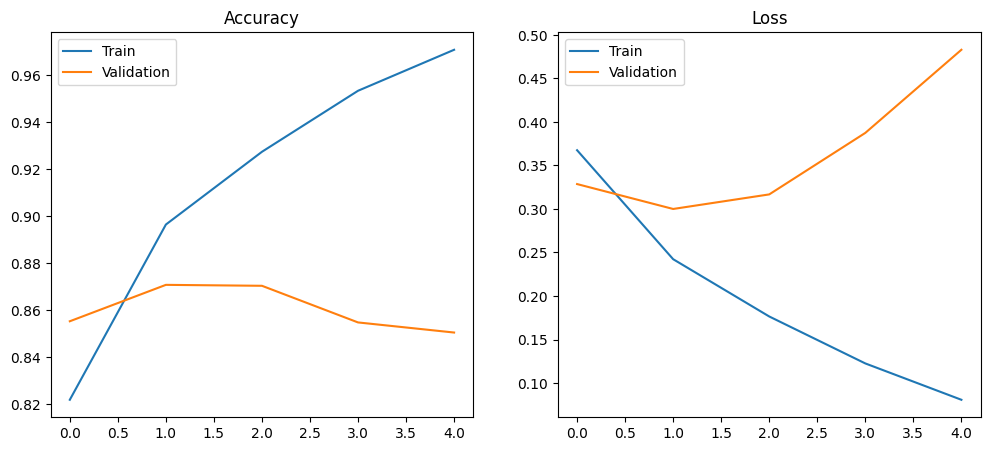

Review: This product exceeded all my expectations!...
→ NEGATIVE (84.2% confidence)

Review: Worst purchase ever, complete waste of money...
→ NEGATIVE (99.9% confidence)

Review: It's okay but could be better...
→ NEGATIVE (70.0% confidence)



In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load and Prepare Data
url = "https://docs.google.com/spreadsheets/d/1UL-RpshvZgoQlb4P8o3iGBwCaw6-GFdI19jLvoojaSs/export?format=csv"
df = pd.read_csv(url)

# Clean and convert labels
df['sentiment'] = df['sentiment'].str.lower().map({'positive': 1, 'negative': 0})
texts = df['review'].astype(str).values
labels = df['sentiment'].values

# 2. Text Preprocessing
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = min(max(len(x) for x in sequences), 100)  # Dynamic padding length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# 4. Build Optimized LSTM Model
model = Sequential([
    Embedding(input_dim=8000, output_dim=64, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Train with Early Stopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight={0: 0.8, 1: 1.2}  # Adjust for class imbalance
)

# 6. Evaluation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')
plt.show()

# 7. Prediction Function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    prob = model.predict(padded, verbose=0)[0][0]
    sentiment = 'positive' if prob > 0.5 else 'negative'
    confidence = prob if prob > 0.5 else 1-prob
    return sentiment, float(confidence)

# Test samples
test_reviews = [
    "This product exceeded all my expectations!",
    "Worst purchase ever, complete waste of money",
    "It's okay but could be better"
]

for review in test_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"Review: {review[:50]}...")
    print(f"→ {sentiment.upper()} ({confidence*100:.1f}% confidence)\n")